# Exercise 8.7 - Obtain the Specific Heat for a 10 x 10 Square Lattice

## Problem Statement

Obtain the specific heat as a function of temperature for a 10 x 10 square lattice by (1), differentiating the energy and (2), through the fluctuation-dissipation theorem. Show that the two methods give the same result. Which approach is more accurate (for a given amount of computer time)?

## Numerical Model - Metropolis Algorithm

The Ising model predicts the energy required to flip the spin state of a point in the lattice, which is given by the equation

$$E = -J \sum_{\braket{i \, j}} s_i s_j \tag{1}$$

where the sum is over all of the nearest neighbors (top, left, bottom, right). If the energy of that flip is negative, then it is naturally desirable that the spin of the lattice point under evaluation remains unchanged. However, when the energy is positive, we need to apply some form of a random process to handle this case.

Hence we apply the Monte-Carlo method. Implementation of the Monte-Carlo method to add on to the Ising model requires starting out the system (the lattice) in some initial spin state, where each lattice point will be assigned a spin value which can be random or chosen through some pattern. When we arrive to a point in the lattice where a decision must be made as described in the previous paragraph, we generate some random number on the interval $[0,1]$ and compare it againt the Boltzmann distribution, which is given by

$$B = e^{- \frac{E_{\text{flip}}}{k_B T}} \tag{2}$$

where $E_{\text{flip}}$ is the energy that would be added to the system if the spin of that lattice point were to be flipped. If the random number generated $r$ is greater than $B$, then the spin is flipped. If not, then nothing happens to that lattice point and the algorithm moves on to the next point.

Below, I make the software required to simulate this model and build functional operators that can store the data and plot what is needed.

In [53]:
# Ising Model using the algorithm depicted above
import numpy as np
from random import random, randint
import matplotlib.pyplot as plt

class SquareLattice:
    def __init__(self, N : int, J : float = 1.0):
        self.N = N
        self.J = J
        self.lattice = np.zeros((N + 2, N + 2))
        self.FillLattice()
        self.kB = 1
        # Parameters for the characterization of the overall lattice
        self.EVariance = 0.0
        self.E = 0.0
        self.M = 0.0
    
    def FillLattice(self):
        """Randomly fills the lattice with 75% spin up

        Returns:
            None
        """
        # Assigns random spin states to the lattice points on the grid
        for i in range(1, self.N + 1):
            for j in range(1, self.N + 1):
                self.lattice[i][j] = 1.0 if random() <= 0.9 else -1.0
        
        return None
    
    def UpdateParameters(self):
        """Simply updates the total magetic moment and energy of the lattice into private variables

        Returns:
            None
        """
        # Reset the Energy and variance to 0
        self.E = 0.0
        self.EVariance = 0.0
        # Compute the magnetic moment by adding the spins on the lattice
        self.M = np.sum(self.lattice)
        
        # Create a sort of 'truth' kernel which activates on nearest neighbors and deactivates on non-nearest neighbors.
        # This will prove to be a trick to quickly get the nearest neighbor influence
        kernel = np.array([
            [0, 1, 0],
            [1, 0, 1],
            [0, 1, 0]
        ], int)
        
        # Set 2 temporary variables to store ExESquared and SquareExE
        SquareExE = 0.0
        ExESquared = 0.0
        
        for i in range(1, self.N + 1):
            for j in range(1, self.N + 1):
                # Calculate the energy by multiplying the truth kernel onto the 3x3 lattice around the point (i, j)
                # to get only the affecting area (nearest neighbors) and then multiply their sum by the spin at (i, j)
                # times - J to get E
                self.E += - self.J * self.lattice[i, j] * np.sum(kernel * self.lattice[i - 1 : i + 2, j - 1 : j + 2])
                #ExESquared += - self.J * (self.lattice[i, j] * np.sum(kernel * self.lattice[i - 1 : i + 2, j - 1 : j + 2])) ** 2
        
        for i in range(1, self.N + 1):
            for j in range(1, self.N + 1):
                # Calculate the energy once again, but take the difference from the mean, and square it. This adds to the variance term.
                self.EVariance += (- self.J * self.lattice[i, j] * np.sum(kernel * self.lattice[i - 1 : i + 2, j - 1 : j + 2]) - self.E / (self.N * self.N)) ** 2
        
        # Compute and store the variance by dividing by n (sample size) - 1
        self.EVariance /= (self.N * self.N - 1)
        
        return None
    
    def MetropolisAlgorithm(self, T : float):
        """Randomly picks a point in the lattice to update its value to spin up or down depending on its energy with its nearest neighbors

        Args:
            T (float): temperature under evaluation

        Returns:
            None
        """
        # Choose a random point on the lattice to evaluate
        i, j = randint(1, self.N), randint(1, self.N)
        # Calculate the energy of that state
        E = - self.J * self.lattice[i, j] * (self.lattice[i - 1, j] + self.lattice[i, j - 1] + self.lattice[i + 1, j] + self.lattice[i, j + 1])
        
        # Since the energy to flip the state is the negative of its current energy, I simply reverse the directions of inequalities which I stated above
        if (E >= 0):
            self.lattice[i, j] *= - 1.0
        elif (random() < np.exp(E / (self.kB * T))):
            self.lattice[i, j] *= - 1.0
        else:
            pass
        
        self.UpdateParameters()
        return None
    
    def Animate(self, nIters : int, T : float):
        """Animates the Ising model nIters number of times for temp T

        Args:
            nIters (int): number of times to iterate the model
            T (float): temperature evaluated
        """
        for _ in range(nIters):
            self.MetropolisAlgorithm(T = T)
            plt.imshow(self.lattice[1 : -1, 1 : -1], cmap = 'cool')
            plt.draw()
            plt.pause(0.00001)
            plt.clf()
        
        plt.close()
        return
    
    def ParametersVsTemp(self, TMin : float, TMax : float, nPoints : int, nIters : int):
        """Gets the lists and arrays necessary to plot energy and magnetization vs temperature

        Args:
            TMin (float): min temp test to test
            TMax (float): max temp value to test
            nPoints (int): number of temperature points to test in between max and min
            nIters (int): number of Monte-Carlo time steps (the more, the better for accuracy)

        Returns:
            TempArray, EnergyArray, EnergyVarianceArray, MagnetizationArray: arrays for plotting
        """
        
        # Make the arrays and lists to plot against once computation is ended
        T = np.linspace(TMin, TMax, nPoints)
        E = []
        EVariance = []
        M = []
        
        for t in T:
            # Reset the lattice for a new temperature to test
            self.FillLattice()
            
            # I create little parameters e, eV, and m to sum over the values to approximate an average of energy, variance, and magnetization
            e = 0.0
            eV = 0.0
            m = 0.0
            for _ in range(nIters):
                self.MetropolisAlgorithm(T = t)
                
                # Only start accumulating the average if it has been iterated at least 1000 times
                if _ > 1000:
                    # The energy is saved as the sum of the entire lattice, but we only plot the mean
                    e += self.E / (self.N * self.N)
                    eV += self.EVariance
                    # Likewise with M, we only plot the mean
                    m += self.M / (self.N * self.N)
            
            # After running the algorithm nIters number of times, save the energy, variance, and magnetization averages
            E.append(e / (nIters - 1000))
            EVariance.append(eV / (nIters - 1000))
            M.append(m / (nIters - 1000))
        
        return T, E, EVariance, M

# Instantiate the lattice class
latticeStructure = SquareLattice(N = 10, J = 1)

In [54]:
%matplotlib
# Animate the Ising model
latticeStructure.Animate(nIters = 1000, T = 1.0)

Using matplotlib backend: MacOSX


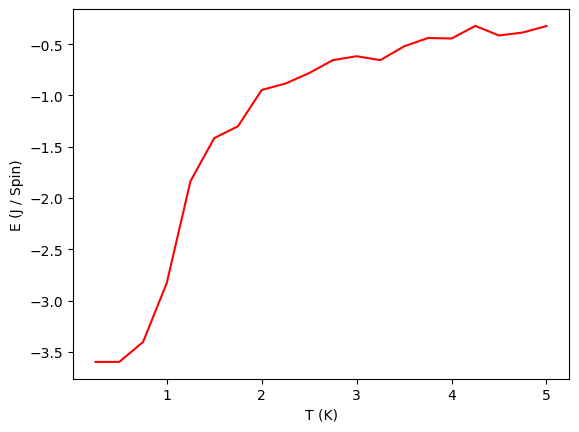

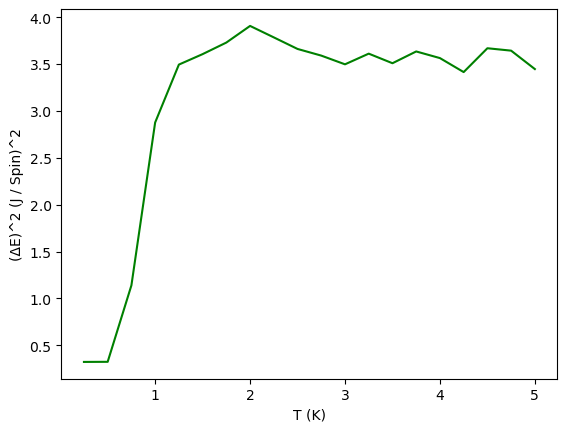

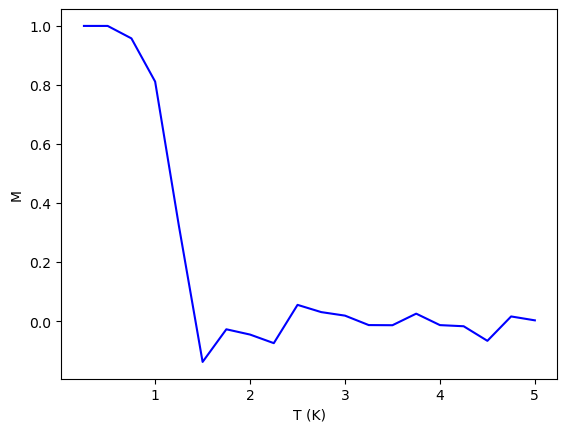

In [55]:
%matplotlib inline
# Compute all of the parameters of the model given a temp range of 0.25 K to 5.0 K with 20 data points and 3000 Monte-Carlo time steps
T, E, EVariance, M = latticeStructure.ParametersVsTemp(TMin = 0.25, TMax = 5.0, nPoints = 20, nIters = 3000)

# Plot average energy
plt.xlabel('T (K)')
plt.ylabel('E (J / Spin)')
plt.plot(T, E, 'r-')
plt.show()

# Plot energy variance
plt.xlabel('T (K)')
plt.ylabel('(ΔE)^2 (J / Spin)^2')
plt.plot(T, EVariance, 'g-')
plt.show()

# Plot magentization mean
plt.xlabel('T (K)')
plt.ylabel('M')
plt.plot(T, M, 'b-')
plt.show()

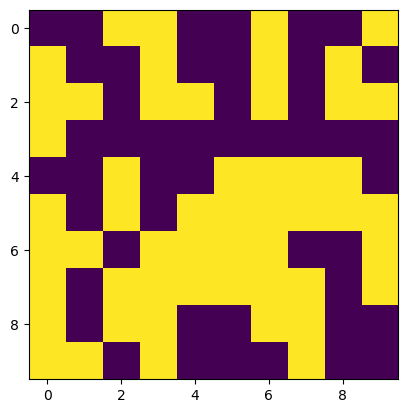

In [56]:
%matplotlib inline
# And to show the results of the algorithm for PDF Format to display
# This is the lattice at T = 5.0 K after 3000 Monte-Carlo time steps
plt.imshow(latticeStructure.lattice[1 : -1, 1 : -1])
plt.show()

## Remarks - Computing $C(T)$

As we can see, the lowest temperatures will enforce states which cause most spins to align as spin ups, thus reducing (minimizing) the energy of the system. Starting out with a grid of 90% spin up helps to speed up the convergence process. Now to find $C(T)$, I will be applying the two methods described above.

## Method 1

The first method will be to numerically differentiate the results of $E$ with respect to $T$. This is because thermodynamics shows the relation

$$C(T) = \frac{d \braket{E}}{d T} \tag{3}$$

where $\braket{E}$ will be the average energy computed of the entire lattice at a certain temperature $T$.

## Method 2

Lastly, I will be making use of the specific heat equation as a function of temperature given by the fluctuation-dissipation theorem

$$C = \frac{(\Delta E)^2}{k_B T^2} \tag{4}$$

I can now model the specific heat as a function of temperature given my computed $\Delta E$ parameter via the Ising model. I'll be sure to make note that the variance of $E$ is defined by

$$(\Delta E)^2 = \braket{E^2} - \braket{E}^2 \tag{5}$$

with

$$\braket{E^2} = \frac{1}{N_m} \sum_{\alpha} E_{\alpha}^2 \hspace{1 in} \braket{E} = \frac{1}{N_m} \sum_{\alpha} E_{\alpha} \tag{6}$$

**NOTE:** Remember that $\braket{E}$ denotes the mean (averge) energy of the entire lattice.

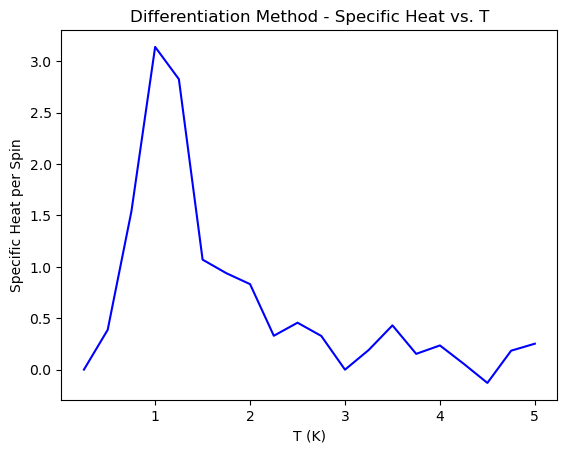

In [57]:
%matplotlib inline
# Method 1 - Differentiation

# Convert Energy and Variance to an array instead of a list
E = np.array(E)
EVariance = np.array(EVariance)
dT = T[1] - T[0] # All dTs are constant
# And then make a space to save the specific heat
C = []

# Save the first derivative using forward difference method
C.append((E[1] - E[0]) / dT)

for i in range(1, len(T) - 1):
    # Center difference method for middle points of the grid
    C.append((E[i + 1] - E[i - 1]) / (2 * dT))

# And finally, save the last derivative using backward difference method
C.append((E[-1] - E[-2]) / dT)

"""
Since E is already in the form of an expected value, or the average of the energy per spin, it can be
directly substituted into equation (3), which is exactly what I have done. Now, to plot!
"""

plt.plot(T, C, 'b-')
plt.title('Differentiation Method - Specific Heat vs. T')
plt.xlabel('T (K)')
plt.ylabel('Specific Heat per Spin')
plt.show()

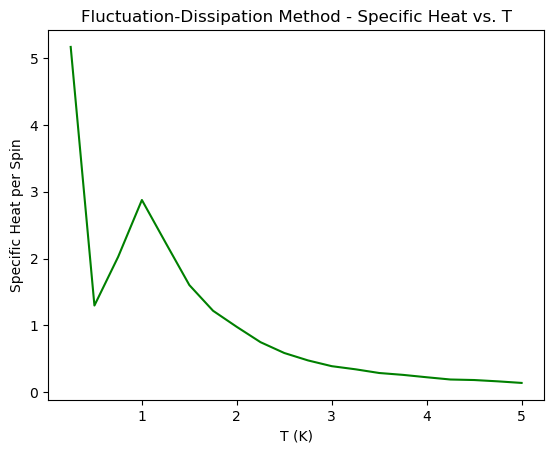

In [58]:
%matplotlib inline
# Method 2 - Fluctuation-Dissipation

"""
A new C value will be found by making use of the variance of E as with equation (4), as opposed to differentiating E vs T.
"""

C = np.array([eV / t ** 2 for eV, t in zip(EVariance, T)])

plt.plot(T, C, 'g-')
plt.title('Fluctuation-Dissipation Method - Specific Heat vs. T')
plt.xlabel('T (K)')
plt.ylabel('Specific Heat per Spin')
plt.show()

## Conclusion

Since my range of temperatures $T$ ran from $0.25 \leq T \leq 5$, a divergence occurs on the fluctuation-dissipation diagram. This was expected, but to match the books plots, I would increase my minimum temperature bound on $T$ from $0.25$ to somewhere around $0.5$. Overall, it is clear to see and very interesting to notice that in fact both methods yield the same description of the specific heat and its behavior as a function of temperature in the lattice.

To discuss the matter of accuracy, it seems that differentiation introduces a lot of noise in the output. That said, keeping track of the variance was not a big cost to the computer to track, even though we added 2 more for-loops to handle this calculation. The time that it took running with and without variance tracking was negligible, and introduced an additional time cost of less than 1 second out of the 70 seconds it takes to run the algorithm. With all this in mind, the fluctuation-dissipation method seems to have the cleanest output and be the most computationally valuable solution to this type of problem.